In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import sklearn
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multiclass import OneVsRestClassifier

In [109]:
def load_data():
    data = pd.read_csv('car.csv', index_col=0, header=None)  # Treats the first column as an index
    data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'eval_level']
    
    return data

In [110]:
def data_preprocessing(data):
    x = data.drop('eval_level', axis=1)
    y = data['eval_level']

    enc = OneHotEncoder(sparse_output=False, drop='first')
    x_enc = enc.fit_transform(x)

    pca = PCA(n_components=0.95)
    x_pca = pca.fit_transform(x_enc)

    return x_pca,y

In [111]:
def split_data(x_pca, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [112]:
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [113]:
def prepare_data():
    # Load data
    data = load_data()
    
    # Preprocess data
    x, y = data_preprocessing(data)
    
    # Split the data
    X_train, X_test, y_train, y_test = split_data(x, y)
    
    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [114]:
def train_evaluate_svm(X_train, X_test, y_train, y_test, kernel='linear', C=1.0):
    # Initialize the SVM model
    svm_model = SVC(kernel=kernel, C=C, probability=True)
    
    # Train the SVM model
    svm_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = svm_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['unacc', 'acc', 'good', 'vgood'])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", report)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['unacc', 'acc', 'good', 'vgood'], 
                yticklabels=['unacc', 'acc', 'good', 'vgood'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return svm_model, y_pred

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

       unacc       0.84      0.91      0.87        78
         acc       0.67      0.73      0.70        11
        good       0.98      0.96      0.97       242
       vgood       1.00      0.73      0.85        15

    accuracy                           0.93       346
   macro avg       0.87      0.83      0.85       346
weighted avg       0.94      0.93      0.93       346



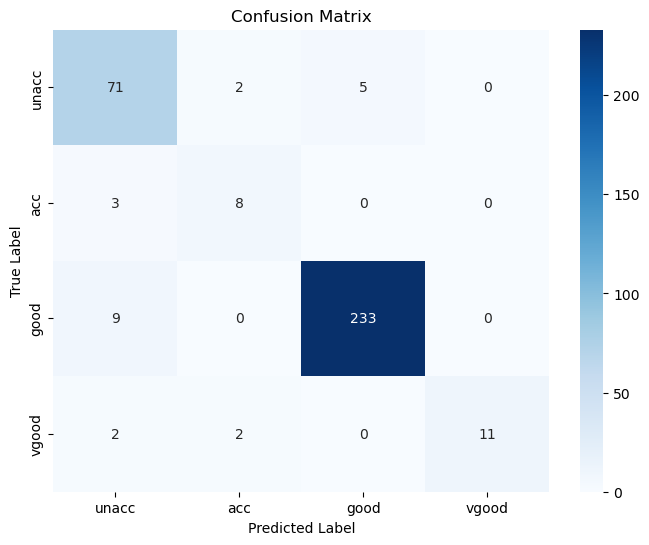

In [115]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data()

# Train and evaluate SVM model
svm_model, y_pred_svm = train_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test, kernel='linear', C=1.0)

In [116]:
def cross_validate_svm(model, X, y, cv=5):
    # Define the cross-validation strategy (e.g., K-Folds with 5 splits)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print the cross-validation scores
    print("Cross-Validation Scores for each fold:", cv_scores)
    print("Average Cross-Validation Accuracy:", cv_scores.mean())
    
    return cv_scores

In [117]:
# Assuming `svm_model` is your trained model and `X_train_scaled`, `y_train` are your training data
cross_val_scores = cross_validate_svm(svm_model, X_train_scaled, y_train)

Cross-Validation Scores for each fold: [0.93501805 0.93862816 0.93140794 0.92028986 0.91666667]
Average Cross-Validation Accuracy: 0.9284021346727359


In [118]:
def train_evaluate_svm_with_roc(X_train, X_test, y_train, y_test, kernel='linear', C=1.0):
    # Initialize the SVM model with probability enabled
    svm_model = SVC(kernel=kernel, C=C, probability=True)
    svm_model.fit(X_train, y_train)
    
    # Predict probabilities for the ROC curve
    y_score = svm_model.predict_proba(X_test)
    
    # Binarize the output labels for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=['unacc', 'acc', 'good', 'vgood'])  # Adjust classes as per your labels
    
    # Compute ROC curve and ROC area for each class
    n_classes = y_test_bin.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting the ROC curve for each class
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class SVM Model')
    plt.legend(loc='best')
    plt.show()

    return svm_model

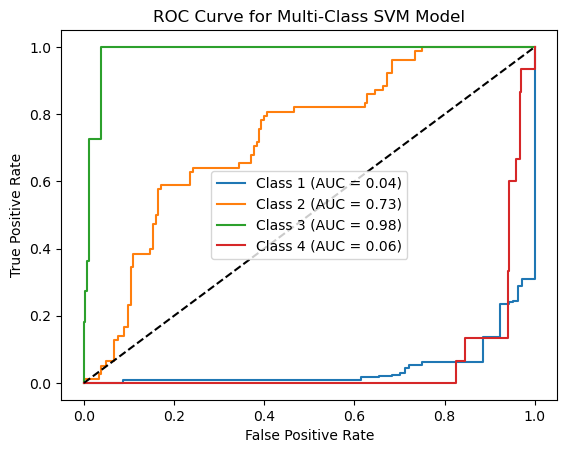

SVC(kernel='linear', probability=True)

In [119]:
train_evaluate_svm_with_roc(X_train_scaled, X_test_scaled, y_train, y_test)

In [120]:
def evaluate_svm_model(y_test, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['unacc', 'acc', 'good', 'vgood'], yticklabels=['unacc', 'acc', 'good', 'vgood'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

         acc       0.84      0.91      0.87        78
        good       0.67      0.73      0.70        11
       unacc       0.98      0.96      0.97       242
       vgood       1.00      0.73      0.85        15

    accuracy                           0.93       346
   macro avg       0.87      0.83      0.85       346
weighted avg       0.94      0.93      0.93       346



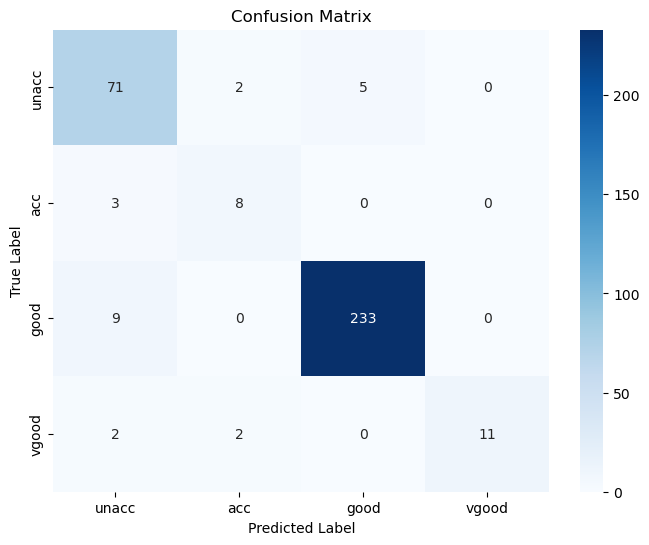

In [121]:
# Call the evaluation function with the true and predicted labels
evaluate_svm_model(y_test, y_pred_svm)